# Comparison with Yeast Strain

### 1. Create Yeast model with Artemisinic Acid Pathway

In [4]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter

# Load the Yeast IMM904 Model
model = models.bigg.iMM904

# Create all metabolites
Amorphadiene = Metabolite(id = 'amorpha', name = 'Amorphadiene', compartment = 'c')
Artemisinic_alcohol = Metabolite(id = 'artem_alcohol', name = 'Artemisinic alcohol', compartment = 'c')
Artemisinic_aldehyde = Metabolite(id = 'artem_aldehyde', name = 'Artemisinic aldehyde', compartment = 'c')
Artemisinic_acid_c = Metabolite(id = 'ARTA_c', name = 'Artemisinic acid_c', compartment = 'c')
Artemisinic_acid_e = Metabolite(id = 'ARTA_e', name = 'Artemisinic acid_e', compartment = 'e')

# Create all reactions
ADS = Reaction('ADS_reaction')
ADS.add_metabolites({
    model.metabolites.frdp_c: -1,
    Amorphadiene: 1
})

CYP1_CYB5 = Reaction('CYP1AV1CY/PCPR1/CYB5_reaction')
CYP1_CYB5.add_metabolites({
    Amorphadiene: -1,
    Artemisinic_alcohol: 1
})

ADH1 = Reaction('ADH1_reaction')
ADH1.add_metabolites({
    Artemisinic_alcohol: -1,
    Artemisinic_aldehyde: 1
})

ALDH1 = Reaction('ALDH1_reaction')
ALDH1.add_metabolites({
    Artemisinic_aldehyde: -1,
    Artemisinic_acid_c: 1
})

Artemisinic_acid_ex = Reaction('ARTA_ex')
Artemisinic_acid_ex.add_metabolites({
    Artemisinic_acid_c: -1,
    Artemisinic_acid_e: 1
})

new_reactions = [ADS, CYP1_CYB5, ADH1, ALDH1, Artemisinic_acid_ex]

model.add_reactions(new_reactions)
model.add_boundary(model.metabolites.get_by_id("ARTA_e"), type="exchange")

model

Name,iMM904
Memory address,0x07fcf82c992b0
Number of metabolites,1231
Number of reactions,1583
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


In [13]:

with model:
    model.objective = model.reactions.ARTA_ex
    solution = model.optimize()
    print('Model objective: ', model.objective)
    print('Value of artemisinic acid secretion: ', solution.objective_value)
    print('Flux Biomass: ', solution.fluxes.BIOMASS_SC5_notrace)

Model objective:  Maximize
1.0*ARTA_ex - 1.0*ARTA_ex_reverse_f17a7
Value of artemisinic acid secretion:  0.9909909909909911
Flux Biomass:  0.0


In [14]:
model.optimize()
model.summary(fva=0.95)

Metabolite,Reaction,Flux,Range,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,[9.394; 10],6,100.00%
nh4_e,EX_nh4_e,1.611,[1.53; 3.635],0,0.00%
o2_e,EX_o2_e,2,[1.543; 2],0,0.00%
pi_e,EX_pi_e,0.05691,[0.05407; 0.3573],0,0.00%
so4_e,EX_so4_e,0.02225,[0.02114; 0.5804],0,0.00%
Metabolite,Reaction,Flux,Range,C-Number,C-Flux
2hb_e,EX_2hb_e,0,[-0.3847; 0],4,0.00%
2mbac_e,EX_2mbac_e,0,[-0.2136; 0],7,0.00%
2mbald_e,EX_2mbald_e,0,[-0.3092; 0],5,0.00%
2mbtoh_e,EX_2mbtoh_e,0,[-0.3294; 0],5,0.00%


### 2. OptGene Analysis

In [15]:
from cameo.strain_design import OptGene

optgene = OptGene(model)

result = optgene.run(target=model.reactions.ARTA_ex, 
                     biomass=model.reactions.BIOMASS_SC5_notrace,
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=5000, population_size=200, max_knockouts=4,
                     plot=False, growth_coupled=False)

Starting optimization at Tue, 22 Nov 2022 16:43:27


/Users/te/opt/anaconda3/lib/python3.9/site-packages/bokeh/models/sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 1), ('y', 0)



HBox()

/Users/te/opt/anaconda3/lib/python3.9/site-packages/bokeh/models/sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 2), ('y', 1)

/Users/te/opt/anaconda3/lib/python3.9/site-packages/bokeh/models/sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 3), ('y', 2)

/Users/te/opt/anaconda3/lib/python3.9/site-packages/bokeh/models/sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 4), ('y', 3)

/Users/te/opt/anaconda3/lib/python3.9/site-packages/bokeh/models/sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 5), ('y', 4)

/Users/te/opt/anaconda3/lib/python3.9/site-packages/bokeh/models/sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 6), ('y', 5)

/Users/te/opt/anaconda3/lib/python3.9/si

Finished after 00:35:56


/Users/te/opt/anaconda3/lib/python3.9/site-packages/bokeh/models/sources.py:205: BokehUserWarning:

ColumnDataSource's columns must be of the same length. Current lengths: ('x', 26), ('y', 25)



In [16]:
result

No solutions found


IndexError: index 0 is out of bounds for axis 0 with size 0

### 3. Gene Regulation Analysis

In [7]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
fseof = FSEOF(model)
result = fseof.run(target=model.reactions.PRPPS)

In [8]:
from pytest import approx

df = result.data_frame
# sorting the dataframe
df = df.sort_values([1], ascending = False)

# removing genes with zero fluxes from dataframe 
removed_zero = (df != approx(0.0)).all(axis=1)
df = df.loc[removed_zero]


df['relative_change_in_flux'] = (df[10]-df[1])/df[10] +1
target_reactions_df = df[df['relative_change_in_flux'] > 1.8]
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
PPA,2.131974,3.108080,4.084186,5.060293,6.036399,7.012505,7.988611,8.963422,9.936623,10.909824,1.804582
ADK1,1.730515,2.745868,3.761221,4.776574,5.791927,6.807280,7.822633,8.837225,9.850871,10.864517,1.840719
PRPPS,1.158836,2.230076,3.301316,4.372557,5.443798,6.515038,7.586279,8.657519,9.728760,10.800000,1.892700
ADPT,1.079024,2.158067,3.237110,4.316152,5.395195,6.474238,7.553281,8.632430,9.711712,10.790993,1.900007
AMPN,1.074119,2.153641,3.233164,4.312686,5.392209,6.471731,7.551253,8.630889,9.710664,10.790439,1.900456
LNS14DM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000181,0.000123,0.000065,2.000000
AASAD1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023597,0.016034,0.008472,2.000000
ASPTAm,0.000000,-0.067588,-0.146947,-0.226306,-0.305665,-0.385024,-0.464383,-0.443722,-0.301512,-0.159303,2.000000
ASPt2m,0.000000,-0.067588,-0.146947,-0.226306,-0.305665,-0.385024,-0.464383,-0.443722,-0.301512,-0.159303,2.000000
ICDHxm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055331,0.251260,0.447188,2.000000


Text(0.5, 1.0, 'Reactions with a relative change in Flux > 80%')

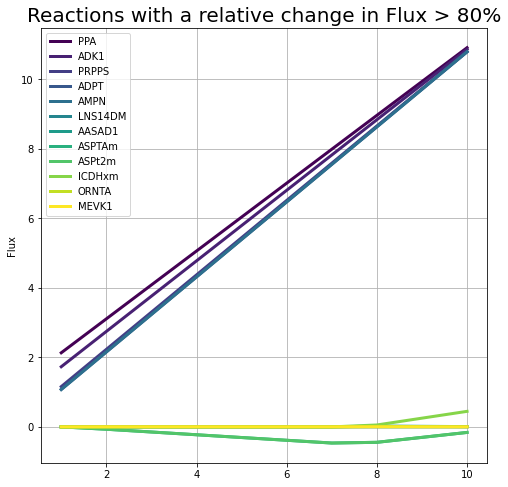

In [9]:
df = target_reactions_df.drop(labels='relative_change_in_flux', axis=1)
fig = df.T.plot(cmap="viridis",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux')
fig.set_title('Reactions with a relative change in Flux > 80%', size=20)

In [18]:
target_reactions_df.head()

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
PPA,2.131974,3.108080,4.084186,5.060293,6.036399,7.012505,7.988611,8.963422,9.936623,10.909824,1.804582
ADK1,1.730515,2.745868,3.761221,4.776574,5.791927,6.807280,7.822633,8.837225,9.850871,10.864517,1.840719
PRPPS,1.158836,2.230076,3.301316,4.372557,5.443798,6.515038,7.586279,8.657519,9.728760,10.800000,1.892700
ADPT,1.079024,2.158067,3.237110,4.316152,5.395195,6.474238,7.553281,8.632430,9.711712,10.790993,1.900007
AMPN,1.074119,2.153641,3.233164,4.312686,5.392209,6.471731,7.551253,8.630889,9.710664,10.790439,1.900456


In [19]:
target_reactions_df.tail()

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
ASPTAm,0.0,-0.067588,-0.146947,-0.226306,-0.305665,-0.385024,-0.464383,-0.443722,-0.301512,-0.159303,2.0
ASPt2m,0.0,-0.067588,-0.146947,-0.226306,-0.305665,-0.385024,-0.464383,-0.443722,-0.301512,-0.159303,2.0
ICDHxm,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055331,0.251260,0.447188,2.0
ORNTA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013579,0.009227,0.004875,2.0
MEVK1,0.0,0.003124,0.002785,0.002447,0.002108,0.001770,0.001431,0.001088,0.000740,0.000391,2.0
